In [1]:
import sys
sys.path.append("/home/dfischer/masterarbeit/src/")

from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn as skl
import _pickle as pickle

import lib.class_distributions as class_distributions
import lib.data_selection as data_selection
import lib.helper_funcs as helper_funcs

import dtreeviz
import logging
# to suppress messages when plotting trees
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# open file

data_folder = Path("../../data/DryBeanDataset/")
model_folder = Path("../../models/DryBeanDataset")
file_to_open = data_folder / "Dry_Bean_Dataset.xlsx"

In [3]:
# read and prepare data

data = pd.read_excel(file_to_open)

labels_dict = {key:value for (value,key) in enumerate(data["Class"].unique())}
data["Class"] = data["Class"].map(labels_dict)
#data.Class.astype("category").cat.codes

# need feature matrix X and labels labels for xgboost
labels = data["Class"]
X = data.drop(["Class"],axis=1,inplace=False)

In [4]:
class_distributions.label_proportions(labels)

6    0.260525
5    0.193667
0    0.148924
4    0.141650
3    0.119756
1    0.097127
2    0.038351
Name: Class, dtype: float64

In [5]:
# prepare smaller dataset with only first num_labels classes of beans

old_classes = [0,1,3,4,5,6]
new_class = 2

# compute number of old labels used
num_labels = len(old_classes)

# relabel for XGBoost
labels = helper_funcs.relabel(labels, old_classes, new_class)

data_small = X[labels < num_labels]
labels_small = labels[labels < num_labels]

# attempt to retrain with new data
data_update = X[labels == num_labels]
labels_update = labels[labels == num_labels]

# also train a model with all the data availale for comparison
data_full = pd.concat([data_small, data_update])
labels_full = pd.concat([labels_small, labels_update])

In [6]:
# split data into train- and test-data

X_train_small, X_test_small, y_train_small, y_test_small = skl.model_selection.train_test_split(data_small, 
                                                    labels_small,
                                                    test_size=.2)

In [7]:
# specify DMatrices

dtrain_small = xgb.DMatrix(X_train_small, label=y_train_small)
dtest_small = xgb.DMatrix(X_test_small, label=y_test_small)

# specify some parameters
num_models = 10
proportion_of_old_data = [i*0.1 for i in range(1,10)]

# specify parameters for XGBoost
num_round = 10
#early_stopping_rounds = num_round*.1
max_depth = 3
eta = .1

param_small = {'max_depth': max_depth, 'eta': eta, 'objective': 'multi:softprob', "num_class": num_labels}
param_small['nthread'] = 4
param_small['eval_metric'] = 'mlogloss'

evallist_small = [(dtrain_small, 'train'), (dtest_small, 'eval')]

In [8]:
# training model with fewer labels
bst_small = xgb.train(param_small,
                      dtrain_small,
                      num_round,
                      evals=evallist_small,
                      #early_stopping_rounds=early_stopping_rounds,
                      verbose_eval=25)

bst_small.save_model(fname=model_folder / 'fewer_class_model.json')

[0]	train-mlogloss:1.56656	eval-mlogloss:1.56855
[25]	train-mlogloss:0.32398	eval-mlogloss:0.33978
[50]	train-mlogloss:0.20262	eval-mlogloss:0.22492
[75]	train-mlogloss:0.17027	eval-mlogloss:0.20268
[99]	train-mlogloss:0.15405	eval-mlogloss:0.19606


In [9]:
print("Accuracy on test data: ", skl.metrics.accuracy_score(np.argmax(bst_small.predict(dtest_small), axis=1), y_test_small))

Accuracy on test data:  0.9247517188693659


In [10]:
# split data into train- and test-data

X_train_update, X_test_update, y_train_update, y_test_update = skl.model_selection.train_test_split(data_update,
                                                                                                    labels_update,
                                                                                                    test_size=.2)

X_train_full, X_test_full, y_train_full, y_test_full = skl.model_selection.train_test_split(data_full,
                                                                                            labels_full,
                                                                                            test_size=.2)

In [11]:
# specify DMatrices

dtrain_update = xgb.DMatrix(X_train_update, label=y_train_update)
dtest_update = xgb.DMatrix(X_test_update, label=y_test_update)

dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full)
dtest_full = xgb.DMatrix(X_test_full, label=y_test_full)


# specify paramters for XGBoost
param_update = {'max_depth': max_depth,
                'eta': eta,
                'objective': 'multi:softprob',
                "num_class": num_labels+1}
param_update['nthread'] = 4
param_update['eval_metric'] = 'mlogloss'

evallist_update = [(dtrain_update, 'train'), (dtest_update, 'eval')]


param_full = {'max_depth': max_depth,
              'eta': eta,
              'objective': 'multi:softprob',
              "num_class": num_labels+1}
param_full['nthread'] = 4
param_full['eval_metric'] = 'mlogloss'

evallist_full = [(dtrain_full, 'train'), (dtest_full, 'eval')]

In [12]:
# training a model with all the training data

bst_full = xgb.train(param_full,
                     dtrain_full,
                     num_round,
                     evals=evallist_full,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=25)

bst_full.save_model(fname=model_folder / 'fewer_class_model_full.json')

[0]	train-mlogloss:1.68543	eval-mlogloss:1.68790
[25]	train-mlogloss:0.33329	eval-mlogloss:0.34514
[50]	train-mlogloss:0.20060	eval-mlogloss:0.21732
[75]	train-mlogloss:0.16687	eval-mlogloss:0.19147
[99]	train-mlogloss:0.15093	eval-mlogloss:0.18448


In [13]:
random_old = []
random_new = []
random_mixed = []
random_full = []


for proportion in proportion_of_old_data:
    print(f"Current target proportion of old data in use: {proportion}")
    
    random_old_tmp = 0
    random_new_tmp = 0
    random_mixed_tmp = 0
    random_full_tmp = 0
    
    for _ in range(num_models):

        _, old_data_part, _, old_y_part = skl.model_selection.train_test_split(data_small,
                                                                                labels_small,
                                                                                test_size=proportion)
        

        data_update2 = pd.concat([old_data_part, data_update])
        labels_update2 = pd.concat([old_y_part, labels_update])

        X_train_update2, X_test_update2, y_train_update2, y_test_update2 = skl.model_selection.train_test_split(data_update2,
                                                                                                                labels_update2,
                                                                                                                test_size=.2)

        # create DMatrices

        dtrain_update2 = xgb.DMatrix(X_train_update2, label=y_train_update2)
        dtest_update2 = xgb.DMatrix(X_test_update2, label=y_test_update2)

        # train model
        bst_update2 = xgb.train(param_update,
                                  dtrain_update2,
                                  num_round,
                                  evals=evallist_update,
                                  early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=False,
                                  xgb_model=model_folder/"fewer_class_model.json")

        random_old_tmp += skl.metrics.accuracy_score(np.argmax(bst_update2.predict(dtest_small), axis=1), y_test_small)
        random_new_tmp += skl.metrics.accuracy_score(np.argmax(bst_update2.predict(dtest_update), axis=1), y_test_update)
        random_mixed_tmp += skl.metrics.accuracy_score(np.argmax(bst_update2.predict(dtest_update2), axis=1), y_test_update2)
        random_full_tmp += skl.metrics.accuracy_score(np.argmax(bst_update2.predict(dtest_full), axis=1), y_test_full)
        
    random_old.append(random_old_tmp/num_models)
    random_new.append(random_new_tmp/num_models)    
    random_mixed.append(random_mixed_tmp/num_models)    
    random_full.append(random_full_tmp/num_models)    

Current target proportion of old data in use: 0.1
Current target proportion of old data in use: 0.2
Current target proportion of old data in use: 0.30000000000000004
Current target proportion of old data in use: 0.4
Current target proportion of old data in use: 0.5
Current target proportion of old data in use: 0.6000000000000001
Current target proportion of old data in use: 0.7000000000000001
Current target proportion of old data in use: 0.8
Current target proportion of old data in use: 0.9


### Find the samples closest to the samples of the new class

In [14]:
critical_old = []
critical_new = []
critical_mixed = []
critical_full = []


for proportion in proportion_of_old_data:
    print(f"Current target proportion of old data in use: {proportion}")
    
    # get critical data
    critical_data, critical_data_labels = data_selection.get_samples_euclidean(data_small,
                                                                                  labels_small,
                                                                                  data_update,
                                                                                  ratio_return_total = proportion,
                                                                                  normalization="min_max",
                                                                                  sort_type="closest")
    
    # concatenate with data for new class
    critical_data = pd.concat([critical_data, data_update])
    critical_data_labels = pd.concat([critical_data_labels, labels_update])
    
    # train a model with the new class and the critical data
    
    critical_old_tmp = 0
    critical_new_tmp = 0
    critical_mixed_tmp = 0
    critical_full_tmp = 0

    for _ in range(num_models):
        X_train_critical, X_test_critical, y_train_critical, y_test_critical = skl.model_selection.train_test_split(critical_data,
                                                                                                                    critical_data_labels,
                                                                                                                    test_size=.2)

        dtrain_critical = xgb.DMatrix(X_train_critical, label=y_train_critical)
        dtest_critical = xgb.DMatrix(X_test_critical, label=y_test_critical)

        # "updating" the model with the new class
        bst_critical = xgb.train(param_update,
                                  dtrain_critical,
                                  num_round,
                                  evals=evallist_update,
                                  early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=False,
                                  xgb_model=model_folder/"fewer_class_model.json")

        critical_old_tmp += skl.metrics.accuracy_score(np.argmax(bst_critical.predict(dtest_small), axis=1), y_test_small)
        critical_new_tmp += skl.metrics.accuracy_score(np.argmax(bst_critical.predict(dtest_update), axis=1), y_test_update)
        critical_mixed_tmp += skl.metrics.accuracy_score(np.argmax(bst_critical.predict(dtest_critical), axis=1), y_test_critical)
        critical_full_tmp += skl.metrics.accuracy_score(np.argmax(bst_critical.predict(dtest_full), axis=1), y_test_full)
    
    critical_old.append(critical_old_tmp/num_models)
    critical_new.append(critical_new_tmp/num_models)
    critical_mixed.append(critical_mixed_tmp/num_models)
    critical_full.append(critical_full_tmp/num_models)

Current target proportion of old data in use: 0.1
Current target proportion of old data in use: 0.2
Current target proportion of old data in use: 0.30000000000000004
Current target proportion of old data in use: 0.4
Current target proportion of old data in use: 0.5
Current target proportion of old data in use: 0.6000000000000001
Current target proportion of old data in use: 0.7000000000000001
Current target proportion of old data in use: 0.8
Current target proportion of old data in use: 0.9


In [15]:
critical_old_weighted = []
critical_new_weighted = []
critical_mixed_weighted = []
critical_full_weighted = []

weights = data_selection.create_weights_from_fscores(data_small, bst_small.get_fscore())

for proportion in proportion_of_old_data:
    print(f"Current target proportion of old data in use: {proportion}")
    
    # get critical data
    critical_data, critical_data_labels = data_selection.get_samples_euclidean(data_small,
                                                                                  labels_small,
                                                                                  data_update,
                                                                                  ratio_return_total = proportion,
                                                                                  normalization="min_max",
                                                                                  sort_type="closest",
                                                                                  weights=weights)
    
    # concatenate with data for new class
    critical_data = pd.concat([critical_data, data_update])
    critical_data_labels = pd.concat([critical_data_labels, labels_update])
    
    # train a model with the new class and the critical data
    
    critical_old_tmp = 0
    critical_new_tmp = 0
    critical_mixed_tmp = 0
    critical_full_tmp = 0

    for _ in range(num_models):
        X_train_critical, X_test_critical, y_train_critical, y_test_critical = skl.model_selection.train_test_split(critical_data,
                                                                                                                    critical_data_labels,
                                                                                                                    test_size=.2)

        dtrain_critical = xgb.DMatrix(X_train_critical, label=y_train_critical)
        dtest_critical = xgb.DMatrix(X_test_critical, label=y_test_critical)

        # "updating" the model with the new class
        bst_critical = xgb.train(param_update,
                                  dtrain_critical,
                                  num_round,
                                  evals=evallist_update,
                                  early_stopping_rounds=early_stopping_rounds,
                                  verbose_eval=False,
                                  xgb_model=model_folder/"fewer_class_model.json")

        critical_old_tmp += skl.metrics.accuracy_score(np.argmax(bst_critical.predict(dtest_small), axis=1), y_test_small)
        critical_new_tmp += skl.metrics.accuracy_score(np.argmax(bst_critical.predict(dtest_update), axis=1), y_test_update)
        critical_mixed_tmp += skl.metrics.accuracy_score(np.argmax(bst_critical.predict(dtest_critical), axis=1), y_test_critical)
        critical_full_tmp += skl.metrics.accuracy_score(np.argmax(bst_critical.predict(dtest_full), axis=1), y_test_full)
    
    critical_old_weighted.append(critical_old_tmp/num_models)
    critical_new_weighted.append(critical_new_tmp/num_models)
    critical_mixed_weighted.append(critical_mixed_tmp/num_models)
    critical_full_weighted.append(critical_full_tmp/num_models)

Current target proportion of old data in use: 0.1
Current target proportion of old data in use: 0.2
Current target proportion of old data in use: 0.30000000000000004
Current target proportion of old data in use: 0.4
Current target proportion of old data in use: 0.5
Current target proportion of old data in use: 0.6000000000000001
Current target proportion of old data in use: 0.7000000000000001
Current target proportion of old data in use: 0.8
Current target proportion of old data in use: 0.9


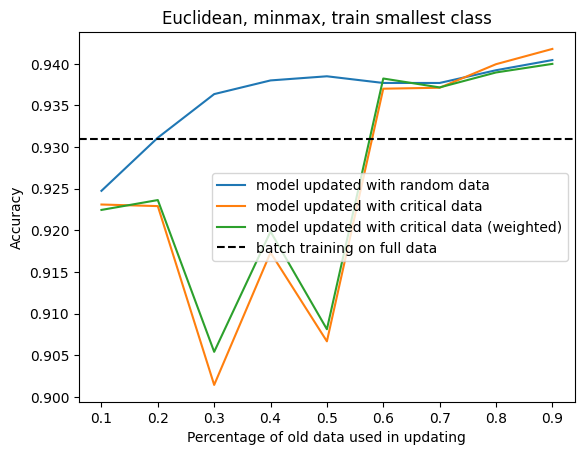

In [19]:
fig = plt.figure()
plt.title(f"Euclidean, minmax, train smallest class")
plt.plot(proportion_of_old_data, random_old, label="model updated with random data")
plt.plot(proportion_of_old_data, critical_old, label="model updated with critical data")
plt.plot(proportion_of_old_data, critical_old_weighted, label="model updated with critical data (weighted)")

plt.axhline(skl.metrics.accuracy_score(np.argmax(bst_full.predict(dtest_full), axis=1), y_test_full),
            color = "black",
            linestyle = "--",
            label = "batch training on full data")
plt.xlabel("Percentage of old data used in updating")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"Euc, minmax, train smallest class.png")
plt.show();

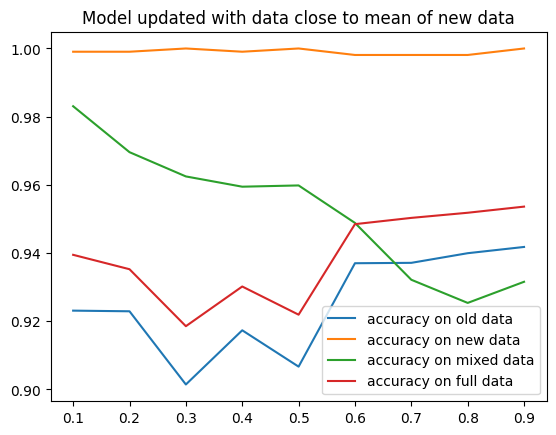

In [17]:
fig = plt.figure()
plt.title("Model updated with data close to mean of new data")
plt.plot(proportion_of_old_data, critical_old, label="accuracy on old data")
plt.plot(proportion_of_old_data, critical_new, label="accuracy on new data")
plt.plot(proportion_of_old_data, critical_mixed, label="accuracy on mixed data")
plt.plot(proportion_of_old_data, critical_full, label="accuracy on full data")
plt.legend();
plt.show();

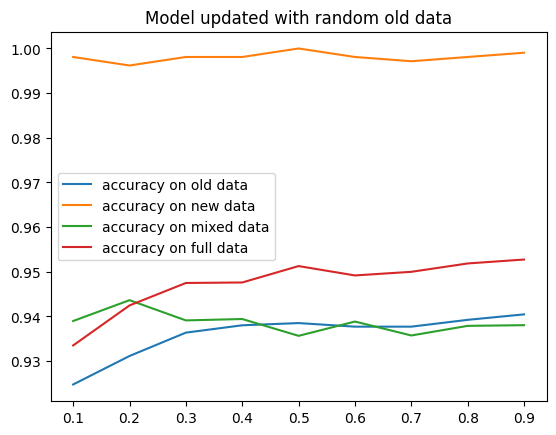

In [18]:
fig = plt.figure()
plt.title("Model updated with random old data")
plt.plot(proportion_of_old_data, random_old, label="accuracy on old data")
plt.plot(proportion_of_old_data, random_new, label="accuracy on new data")
plt.plot(proportion_of_old_data, random_mixed, label="accuracy on mixed data")
plt.plot(proportion_of_old_data, random_full, label="accuracy on full data")
plt.legend();
plt.show();